# Package Dependencies — Graph (Prototype)

This test notebook loads `Package_Dependencies.csv`  
and generates an interactive graph of package dependencies:

- **Node** = package (`originPackage` / `destinationPackage`)
- **Directed edge** = dependency (`origin → destination`)
- **Edge thickness** = `totalDependencies`
- It is limited to the **N “strongest” packages** so the graph remains readable (default is 3, adjustable in the cell).


## How to interpret the dependency colors

### 🔵 Blue edges — normal dependencies
Blue arrows represent **regular package dependencies**.  
They show:
- which package depends on which,
- how information flows,
- which APIs are being used,
- and how many times (the weight number on the edge).

### 🔴 Red edges — part of the longest dependency path
Red arrows are **not ordinary dependencies**.  
They highlight the edges that belong to the **longest dependency chain** in the entire system.
This means they represent:
- the deepest structural path,
- the “main backbone” of the project,
- the chain where changes have the strongest structural impact.

### 🟧 Orange edges — contributors to the longest path
Orange edges are dependencies that:
- are **not directly on** the longest path,
- but **support** or feed into that critical path.
They indirectly influence the main structural chain.

---

## Edge thickness
The arrow thickness (`penwidth`) comes from the normalized dependency weight:

- More package-to-package dependencies → **thicker arrow**
- Fewer dependencies → **thinner arrow**


In [1]:
import os
from pathlib import Path

import pandas as pd
from neo4j import GraphDatabase
from graphviz import Source
from IPython.display import display


pd.set_option("future.no_silent_downcasting", True)

# Base directories for reports and graph visualizations
ROOT_DIRECTORY = os.environ.get("ROOT_DIRECTORY", str(Path("..").resolve()))
REPORTS_DIR = Path(os.environ.get("REPORTS_DIR", str(Path(ROOT_DIRECTORY) / "reports"))).resolve()
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Directory where graph images will be stored
GRAPH_OUT_DIR = REPORTS_DIR / "graph-visualizations"
GRAPH_OUT_DIR.mkdir(parents=True, exist_ok=True)


# --- Neo4j driver ---
driver = GraphDatabase.driver(
    uri="bolt://localhost:7687",
    auth=("neo4j", os.environ.get("NEO4J_INITIAL_PASSWORD"))
)
driver.verify_connectivity()
print("Connected to Neo4j.")



Connected to Neo4j.


In [2]:
#Helpers

def get_cypher_query_from_file(filename: Path) -> str:
    """Read a Cypher file and return its content as a single string."""
    with open(filename, encoding="utf-8") as file:
        return " ".join(file.readlines())


def query_cypher_to_data_frame(filename: Path, parameters_=None) -> pd.DataFrame:
    """Execute a Cypher query from a file and return the result as a pandas DataFrame."""
    if parameters_ is None:
        parameters_ = {}
    query = get_cypher_query_from_file(filename)
    records, summary, keys = driver.execute_query(query, parameters_=parameters_)
    return pd.DataFrame([r.values() for r in records], columns=keys)

def export_graph(src: Source,
                 base_filename: str,
                 scope_package: str | None = None,
                 path_limit: int | None = None) -> Path:
    
    parts = [base_filename]

    if scope_package:
        # Replace dots with underscores to avoid weird filenames
        normalized_scope = scope_package.replace(".", "_")
        parts.append(f"scope={normalized_scope}")
    else:
        parts.append("scope=FULL")

    if path_limit is not None:
        parts.append(f"limit={path_limit}")

    final_stem = "__".join(parts)  # e.g. java-package-longest-path__scope=com_myapp__limit=15

    svg_stem_path = GRAPH_OUT_DIR / final_stem

    # Render SVG; cleanup=True removes the intermediate .gv file
    out_path_str = src.render(
        filename=str(svg_stem_path),
        format="svg",
        cleanup=True,
    )

    out_path = Path(out_path_str).resolve()
    print(f"SVG saved at: {out_path}")
    return out_path


In [3]:
# Root package scope: only packages whose FQN starts with this prefix will be projected.
# If empty or None, the full graph will be used.

env_scope = os.environ.get("SCOPE_PACKAGE", "").strip()

# You can override the environment value here if you want:
scopePackage = env_scope  # e.g. "com.mycompany.myapp"

print("scopePackage used for projection:", repr(scopePackage))


package_path_finding_parameters = {
    "dependencies_projection": "java-package-path-finding-notebook",
    "dependencies_projection_node": "Package",
    "dependencies_projection_weight_property": "weight",
    "scopePackage": scopePackage,
}


scopePackage used for projection: 'com.salesmanager'


In [4]:
def create_scoped_package_projection(parameters: dict) -> bool:
    """
    Create a directed GDS projection for Java package dependencies,
    filtered by the given scopePackage (root package), using the
    modern Cypher projection (gds.graph.project aggregation function).
    """

    graph_name = parameters["dependencies_projection"] + "-cleaned"
    scope = parameters.get("scopePackage")

    # Drop previous projection if it exists (ignore errors)
    try:
        drop_query = """
        CALL gds.graph.drop($graph_name, false)
        YIELD graphName
        RETURN graphName
        """
        records, summary, keys = driver.execute_query(
            drop_query,
            parameters_={"graph_name": graph_name}
        )
        if records:
            print(f"Previous projection '{graph_name}' dropped.")
    except Exception as e:
        print(f"[info] No previous projection '{graph_name}' to drop (or harmless error): {e}")

    # New-style Cypher projection using gds.graph.project as an aggregation function.
    # Note: this projects only packages that participate in at least one DEPENDS_ON relationship.
    project_query = """
    MATCH (p1:Package)-[d:DEPENDS_ON]->(p2:Package)
    WHERE
      $scopePackage IS NULL
      OR trim($scopePackage) = ""
      OR (p1.fqn STARTS WITH $scopePackage AND p2.fqn STARTS WITH $scopePackage)

    WITH gds.graph.project(
      $graph_name,
      p1,                          // source node
      p2,                          // target node
      {
        relationshipProperties: {  // relationship properties on the in-memory graph
          weight: d.weight         // use the 'weight' property from DEPENDS_ON
        }
      }
    ) AS g

    RETURN
      g.graphName      AS graphName,
      g.nodeCount      AS nodeCount,
      g.relationshipCount AS relationshipCount
    """

    records, summary, keys = driver.execute_query(
        project_query,
        parameters_={
            "graph_name": graph_name,
            "scopePackage": scope,
        }
    )

    df_proj = pd.DataFrame([r.values() for r in records], columns=keys)
    print("Scoped GDS projection created (new Cypher projection):")
    display(df_proj)

    return not df_proj.empty

In [5]:
is_package_data_available = create_scoped_package_projection(package_path_finding_parameters)
print("is_package_data_available:", is_package_data_available)


Previous projection 'java-package-path-finding-notebook-cleaned' dropped.
Scoped GDS projection created (new Cypher projection):


,graphName,nodeCount,relationshipCount
0,java-package-path-finding-notebook-cleaned,214,1034


is_package_data_available: True


In [6]:
# Number of longest paths to include (used as $pathLimit in the Cypher query)
pathLimit = 3  # change to 5, 10, 20, ... as needed

package_path_finding_parameters_with_limit = {
    **package_path_finding_parameters,
    "pathLimit": pathLimit,
}

print("Using pathLimit =", pathLimit)


Using pathLimit = 3


In [7]:
if not is_package_data_available:
    print("[info] No projected package data available. Check the scoped projection.")
else:
    cypher_path = Path("../cypher/Path_Finding/Path_Finding_6_Longest_paths_contributors_for_graphviz_custom.cypher")

    df_longest = query_cypher_to_data_frame(
        cypher_path,
        package_path_finding_parameters_with_limit
    )

    print("Rows returned:", len(df_longest))
    print("Columns:", list(df_longest.columns))
    display(df_longest.head())


Rows returned: 21
Columns: ['graphVizDotNotationLine']


,graphVizDotNotationLine
0,"""core.business.repositories.merchant"" -> ""core..."
1,"""core.business.services.reference.init"" -> ""co..."
2,"""core.business.services.catalog.product.type"" ..."
3,"""core.business.services.merchant"" -> ""core.bus..."
4,"""core.business.services.merchant"" -> ""core.bus..."


In [8]:
template_body = """
fontname = "Helvetica,Arial,sans-serif";
node [fontname = "Helvetica,Arial,sans-serif";];
edge [fontname = "Helvetica,Arial,sans-serif"; fontsize = 10;];
node [style = filled; fillcolor = "0.560 0.400 0.999";];
node [color = "0.560 0.900 0.700";];
edge [color = "0.560 0.900 0.700";];
""".rstrip("\\n")


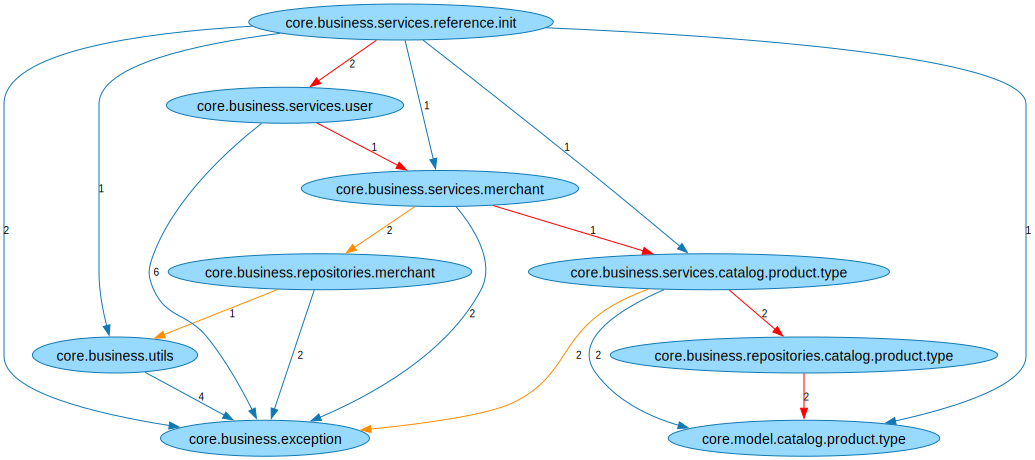

SVG saved at: /Users/jonathan.nervaez/Documents/AppModPractice/E2E-decomposition/reports/graph-visualizations/java-package-longest-path__scope=com_salesmanager__limit=3.svg


In [9]:
from graphviz import Source
from IPython.display import display

# Build DOT source and render with GraphViz
if "df_longest" not in globals():
    print("[info] df_longest is not defined; run the Cypher query cell first.")
elif df_longest.empty:
    print("[info] Longest paths query returned no data.")
else:
    col_name = "graphVizDotNotationLine"
    if col_name not in df_longest.columns:
        raise ValueError(f"Column '{col_name}' not found in query result.")

    # Collect edge lines (each row contains a full DOT edge line)
    edge_lines = [
        str(line)
        for line in df_longest[col_name].dropna().unique()
    ]

    # Assemble DOT graph using the original JohT template body
    dot_lines = []
    dot_lines.append("strict digraph lightblue_template {")
    dot_lines.append(template_body)
    for line in edge_lines:
        dot_lines.append("    " + line)
    dot_lines.append("}")

    dot_source = "\n".join(dot_lines)

    src = Source(dot_source)

    # Show in notebook
    display(src)

    # Export to SVG file under reports/graph-visualizations
    export_graph(
        src=src,
        base_filename="java-package-longest-path",
        scope_package=scopePackage,
        path_limit=pathLimit,
    )


In [10]:
print("Done")

Done
